In [23]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import style
from scipy.integrate import quad
from scipy.integrate import simps
from scipy.interpolate import interp1d
from scipy import constants
# The 'inline' statement keeps the plot windows from showing up as
# independent windows.  Instead, they show up in the notebook.
%matplotlib inline
# make all lines have this thickness by default
mpl.rcParams['lines.linewidth'] = 2
# set a default figure size
mpl.rcParams['figure.figsize'] = (8, 5)



style.use('default')
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('font', size=16)          # controls default text sizes
plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=16)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=12)    # fontsize of the tick labels
plt.rc('ytick', labelsize=12)    # fontsize of the tick labels
plt.rc('legend', fontsize=14)    # legend fontsize
plt.rc('figure', titlesize=18)   # fontsize of the figure title

# -----------------------
# user-defined settings
# -----------------------
T = 300 # lattice temperature, Kelvin
tox = 10e-9 * 100 # nm oxide converted to cm
Nd = 1e10 # donor doping concentration, # / cm^3
Na = 1e16 # acceptor doping concentration, # / cm^3
CBO = 3.5 # SiO2/Si conduction band offset, eV
VBO = 4.4 # SiO2/Si valence band offset, eV

# -----------------------
# physical constants
# -----------------------
e0 = constants.epsilon_0 / 100 # permittivity of free space, F / cm
q = constants.e # elementary charge, Coulombs
k = constants.k/q # Boltzmann constant, eV / K

# -----------------------
# material parameters 
# -----------------------
es  = 11.7 # relative permittivity, silicon
eox = 3.9  # relative permittivity, SiO2
chi_s  = 4.05 # electron affinity, silicon, eV
phi_m  = 4.3  # metal work function, eV
chi_ox = 0.95 # SiO2 electron affinity
Eg_ox  = 8    # SiO2 silicon-like bandgap
# bandgap, silicon, eV
#Eg = 1.17 - 4.73e-4 * T ** 2 / (T + 636.0)
Eg = 1.12
# effective valence band DOS, silicon, # / cm^3
#Nv = 3.5e15 * T ** 1.5
Nv = 1.04e19*(T/300)**(1.5)
# effective conduction band DOS, silicon, # / cm^3
#Nc = 6.2e15 * T ** 1.5
Nc=2.89e19*(T/300)**(1.5)

def solve_bisection(func, target, xmin, xmax):
    """
    Returns the independent value x satisfying func(x)=value.
    - uses the bisection search method
      https://en.wikipedia.org/wiki/Bisection_method

    Arguments:
        func - callable function of a single independent variable
        target - the value func(x) should equal
        [xmin, xmax] - the range over which x can exist
    """
    tol = 1e-15 # when |a - b| <= tol, quit searching
    max_iters = 5e3 # maximum number of iterations
    a = xmin
    b = xmax
    cnt = 1
    # before entering while(), calculate Fa
    Fa = target - func(a)
    c = a

    # bisection search loop
    while np.abs(a - b) > tol and cnt < max_iters:
        cnt += 1
        # make 'c' be the midpoint between 'a' and 'b'
        c = (a + b) / 2.0
        # calculate at the new 'c'
        Fc = target - func(c)

        if Fc == 0:
            # 'c' was the sought-after solution, so quit
            break
        elif np.sign(Fa) == np.sign(Fc):
            # the signs were the same, so modify 'a'
            a = c
            Fa = Fc
        else:
            # the signs were different, so modify 'b'
            b = c

    if cnt == max_iters:
        print('WARNING: max iterations reached')

    return c

# -----------------------
# dependent calculations
# -----------------------
# intrinsic carrier concentration, silicon, # / cm^3
#ni = np.sqrt(Nc * Nv) * np.exp(-Eg / (2 * k * T))
ni = 1.45e10
# Energy levels are relative to one-another in charge expressions.
# - Therefore, it is OK to set Ev to a reference value of 0 eV.
# Usually, energy levels are given in Joules and one converts to eV.
# - I have just written each in eV to save time.
Ev = 0 # valence band energy level
Ec = Eg # conduction band energy level
E0 = Ec + chi_s # vacuum energy
Ei = Eg/2 + k * T * np.log(Nv / Nc) # intrinsic energy level
#Ei = 0.560
phit = k * T  # thermal voltage, eV
# get the Fermi level in the bulk where there is no band-bending
n = lambda Ef: Nc * np.exp((-Ec + Ef) / phit)
p = lambda Ef: Nv * np.exp((Ev - Ef) / phit)
func = lambda Ef: p(Ef) - n(Ef) + Nd - Na
Ef = solve_bisection(func, 0, Ev, Ec)
# oxide capacitance per unit area, F / cm^2
Coxp = eox * e0 / tox    
# if both Nd and Na are zero, then make one slightly higher
# calculate effective compensated doping densities
# - assume complete ionization
if Na > Nd:
    Na = Na - Nd
    Nd = 0
    # compute semiconductor work function (energy from vacuum to Ef)
    phi_s = chi_s + Eg/2 + k * T * np.log(Na/ni)
    # flatband voltage and its constituent(s)
    # - no defect-related charges considered
    phi_ms = phi_m - phi_s # metal-semiconductor workfunction, eV
    Vfb = phi_ms # flatband voltage, V
    phi_p = - k * T * np.log((Na-Nd)/(ni))
    Vth =  Vfb + 2*np.abs(phi_p) + np.sqrt(2*es*e0*q*Na*2*np.abs(phi_p))/Coxp
    gamma = (np.sqrt(2 * es * e0 * q * Na)) / (Coxp)
    if (1-(4*Vfb)/(gamma**2)) >= 0:
        xd0 = (es * e0) / (Coxp) * (np.sqrt(1-(4*Vfb)/(gamma**2))-1)
    else:
        xd0 = 0
        
    LD = np.sqrt((es*e0*phit)/(q*Na))
    xdM = np.sqrt((2 * es * e0 * 2 * np.abs(phi_p))/(q * Na))
    device_type = 'nMOS'
else:
    Nd = Nd - Na
    Na = 0
    # compute semiconductor work function (energy from vacuum to Ef)
    phi_s = chi_s + Eg/2 - k * T * np.log(Nd/ni)
    # flatband voltage and its constituent(s)
    # - no defect-related charges considered
    phi_ms = phi_m - phi_s # metal-semiconductor workfunction, eV
    Vfb = phi_ms # flatband voltage, V
    phi_n = k * T *np.log((Nd-Na)/(ni))
    Vth =  Vfb - 2*np.abs(phi_n) - np.sqrt(2*es*e0*q*Nd*2*np.abs(phi_n))/Coxp
    
    gamma = (np.sqrt(2 * es * e0 * q * Nd)) / (Coxp)
    if (1+(4*Vfb)/(gamma**2)) >= 0:
        xd0 = (es * e0) / (Coxp) * (np.sqrt(1+(4*Vfb)/(gamma**2))-1)
    else:
        xd0 = 0
        
    LD = np.sqrt((es*e0*phit)/(q*Nd))
    xdM = np.sqrt((2 * es * e0 * 2 * np.abs(phi_n))/(q * Nd))
    device_type = 'pMOS'

# oxide capacitance per unit area, F / cm^2
Coxp = eox * e0 / tox    

# -----------------------
# define the SPE
# -----------------------
# compute equilibrium carrier concentrations
n_o = Nc * np.exp((-Ec + Ef) / phit)
p_o = Nv * np.exp((Ev - Ef) / phit)
# define the charge function so it can be used in the SPE
f = lambda psis: psis * (Na - Nd) \
  + phit * p_o * (np.exp(-psis / phit) - 1) \
  + phit * n_o * (np.exp(psis / phit) - 1)
Qs = lambda psis: -np.sign(psis) * np.sqrt(2 * q * e0 * es * f(psis))
SPE = lambda psis: Vfb + psis - Qs(psis) / Coxp
# define the electric field for use in computing y(psi)
E = lambda psi: np.sign(psi) * np.sqrt(2 * q / (es * e0) * f(psi))

In [24]:
print('Vth = %0.4g V'   % (Vth))
print('Vfb = %0.4g V'   % (Vfb))
print('gamma = %0.4g sqrt(V)'   % (gamma))
if device_type == "nMOS":
    print('phip = %0.4g V'  % (phi_p))
else:
    print('phin = %0.4g V'  % (phi_n))
print ('xd0 = %0.4g nm'  % (xd0*1e7))
print ('LD = %0.4g nm'  % (LD*1e7))
print ('xd_max = %0.4g nm'  % (xdM*1e7))


Vth = 0.1767 V
Vfb = -0.6576 V
gamma = 0.1668 sqrt(V)
phip = -0.3476 V
xd0 = 263.1 nm
LD = 40.88 nm
xd_max = 299.8 nm


In [25]:
# -----------------------
# y-computation functions
# -----------------------
# this is the integrand needed to compute y
integrand_y = lambda psi: 1 / E(psi)

def compute_y_vs_psi(psis):
    """
    This function creates a 'psi' variable ranging from psis to ~zero.
    It then computes the y-values corresponding to every value in psi.

    psis is the surface potential and must be a scalar constant.
    """
    # handle the flatband case
    if psis == 0:
        y = np.linspace(0, 150, 1001) * 1e-7 # convert nm to cm
        psi = 0 * y
        return y, psi
    # (1) let semiconductor potential range from psis to near-zero
    # - could construct psi linearly and have a coarse y as psi -> 0
    # - could construct psi log-spaced to make y more evenly spaced
    # - solution: do a mixture 
    psi1 = np.linspace(psis, psis * 0.5, 121) # linear spacing near y=0
    psi2 = np.logspace(                      # log spacing toward bulk
        np.log10(np.abs(psis * 0.5)), 
        np.log10(np.abs(psis * 1.75e-4)), 
        1001
    )
    if psis < 0:
        psi2 = -1 * psi2
    # combine the arrays, but leave out the common point (psis * 0.5)
    psi = np.hstack((psi1, psi2[1:]))
    # (2) call compute_y() at every value in psi
    # collect the returned y-values in an array
    y = np.array([])
    for value in psi:
        y_current, error = quad(integrand_y, value, psis)
        y = np.hstack((y, y_current))
    return y, psi

Vgb = -8.604e-16 V
Vth = 0.1767 V
Vfb = -0.6576 V
Vox = 0.1194 V
psis = 0.5381 V
phip = -0.3476 V
xd = 263.8 nm
xd_max = 299.8 nm


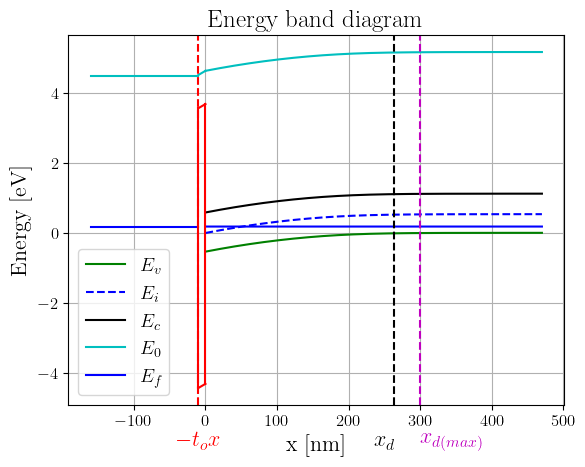

In [26]:
if device_type == "nMOS":
    phi  = phi_p
    Nsub = Na
else:
    phi = phi_n
    Nsub = Nd
# -----------------------
# choose a potential to plot
# -----------------------
#psis = Ev - Ef                    # (very) strong accumulation
#psis = 0                          # flatband
# psis = Ei - Ef                    # weak inversion
#psis = 2 * (-phi)              # strong inversion 
#psis = 2 * (Ei - Ef) + 3 * phit   # stronger inversion
#psis = Ec - Ef                    # (very) strong inversion
psis = solve_bisection(           # zero gate-bulk bias
    SPE, 0, Ev - Ef, Ec - Ef
)
#psis = 0.93

# compute the corresponding Vgb value
Vgb = SPE(psis)

# create figure, label axes, turn grid on
plt.figure(1)
plt.title("Energy band diagram")
plt.xlabel('x [nm]')
plt.ylabel('Energy [eV]')
plt.grid(True)

# get psiox from the potential balance equation (see SPE derivation)
psiox = Vgb - psis - phi_ms

# construct the psi vs y curve
y, psi = compute_y_vs_psi(psis)
# y and tox are in cm, so convert to nm
y = y / 100 * 1e9
toxnm = tox / 100 * 1e9


# plot the conduction/intrinsic/valence bands/vacuum
plt.plot(y, Ev - psi, 'g'  , label="$E_v$")
plt.plot(y, Ei - psi, 'b--', label="$E_i$")
plt.plot(y, Ec - psi, 'k'  , label="$E_c$")
plt.plot(y, E0 - psi, 'c'  , label="$E_0$")

# plot the fermi level
plt.plot(y, 0 * y + Ef, 'b',  label="$E_f$")

# plot the SiO2 bands
plt.plot([0, 0], [E0 - chi_ox - psis , E0 - chi_ox - psis - Eg_ox], 'r')
plt.plot(
    [-toxnm, -toxnm], 
    [E0 - chi_ox - psis - psiox , E0 - chi_ox - psis - Eg_ox - psiox], 
    'r'
)


#plt.plot([0, 0], [Ev - psis - VBO, Ec - psis + CBO], 'r')
#plt.plot(
#    [-toxnm, -toxnm], 
#    [Ev - psis - VBO - psiox, Ec - psis + CBO - psiox], 
#    'r'
#)

plt.plot([-toxnm, 0], [E0 - psis - psiox, E0 - psis], 'c')
plt.plot([-toxnm, 0], [E0 - chi_ox - psis - psiox, E0 - chi_ox - psis], 'r')
plt.plot([-toxnm, 0], [E0 - chi_ox - psis - Eg_ox - psiox, E0 - chi_ox - psis - Eg_ox], 'r')

# plot the vacuum energy on metal side
plt.plot(
    [-toxnm - xdM/200*1e9, -toxnm], 
    [Ef - phi_ms - psis - psiox + phi_m, Ef - phi_ms - psis - psiox + phi_m],
    'c'
)

# plot the gate's Fermi level
plt.plot(
    [-toxnm - xdM/200*1e9, -toxnm], 
    [Ef - phi_ms - psis - psiox, Ef - phi_ms - psis - psiox],
    'b'
)

if device_type == "nMOS":
    if psis<0:
        xd=0
    else:
        xd = np.sqrt((2 * es * e0 * np.abs(psis))/(q * Nsub))
else:
    if psis>0:
        xd=0
    else:
        xd = np.sqrt((2 * es * e0 * np.abs(psis))/(q * Nsub))

# plot relevant x poxitions
plt.axvline(x=-tox*1e7, color='r', linestyle='--')
if xd != 0:
    plt.axvline(x=xd*1e7, color='k', linestyle='--')
else:
    plt.axvline(x=LD*1e7, color='k', linestyle='--')
plt.axvline(x=xdM*1e7, color='m', linestyle='--')
ax = plt.gca()
plt.text(-tox*1e7, -.07, '$-t_ox$', color='r', transform=ax.get_xaxis_transform(), ha='center', va='top')
if xd != 0:
    plt.text(xd*1e7, -.07, '$x_d$', color='k', transform=ax.get_xaxis_transform(), ha='right', va='top')
else:
    plt.text(LD*1e7, -.02, '$L_D$', color='k', transform=ax.get_xaxis_transform(), ha='left', va='top')
plt.text(xdM*1e7, -.07, '$x_{d(max)}$', color='m', transform=ax.get_xaxis_transform(), ha='left', va='top')

plt.legend()

plt.savefig("Images/Energy_band.pdf")
plt.savefig("Images/Energy_band")

print('Vgb = %0.4g V'   % (Vgb))
print('Vth = %0.4g V'   % (Vth))
print('Vfb = %0.4g V'   % (Vfb))
print('Vox = %0.4g V' % (psiox))
print('psis = %0.4g V'  % (psis))
if device_type == "nMOS":
    print('phip = %0.4g V'  % (phi_p))
else:
    print('phin = %0.4g V'  % (phi_n))
print ('xd = %0.4g nm'  % (xd*1e7))
print ('xd_max = %0.4g nm'  % (xdM*1e7))

# Charge plots ("exact")

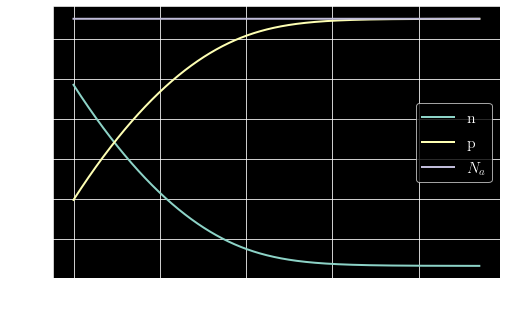

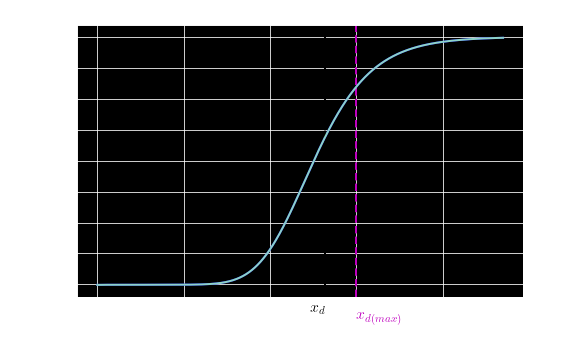

<Figure size 576x360 with 0 Axes>

In [15]:
if xdM <= tox:
    xlim = 10*tox
else:
    xlim = xdM

# define the components of rho
n = n_o * np.exp(psi / phit)
p = p_o * np.exp(-psi / phit)
rho_by_q = p - n + Nd - Na
rho = rho_by_q * q

# plot the components of rho
plt.figure(2)
plt.xlabel('x [nm]', fontsize=14)
plt.ylabel('[cm$^{-3}$]', fontsize=14)
plt.grid(True)
plt.semilogy(y, n, label='n', linewidth=2)
plt.semilogy(y, p, label='p', linewidth=2)
if device_type == 'nMOS':
    plt.semilogy(y, Na + 0 * y, label='$N_a$')
else:
    plt.semilogy(y, Nd + 0 * y, label='$N_d$')
plt.legend(loc='best', prop={'size': 16})

# show magnitude of rho on a log scale
plt.figure(3)
plt.title("Charge density")
plt.xlabel('x [nm]')
plt.ylabel('$\\rho$ [C cm$^{-3}$]')
plt.grid(True)
plt.plot(y, (rho),'b', label='$\\rho/q$')

# plot relevant x poxitions
if xd != 0:
    plt.axvline(x=xd*1e7, color='k', linestyle='--')
else:
    plt.axvline(x=LD*1e7, color='k', linestyle='--')
plt.axvline(x=xdM*1e7, color='m', linestyle='--')
ax = plt.gca()
if xd != 0:
    plt.text(xd*1e7, -.01, '$x_d$', color='k', transform=ax.get_xaxis_transform(), ha='right', va='top')
else:
    plt.text(LD*1e7, -.01, '$L_D$', color='k', transform=ax.get_xaxis_transform(), ha='left', va='top')
plt.text(xdM*1e7, -.05, '$x_{d(max)}$', color='m', transform=ax.get_xaxis_transform(), ha='left', va='top')

ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis

ax2.set_ylabel('$cm^{-3}$')  #
ax2.plot(y, rho_by_q )
ax2.tick_params(axis='y')

plt.show()

plt.savefig("Images/Charge_desity.pdf")

# Electric field

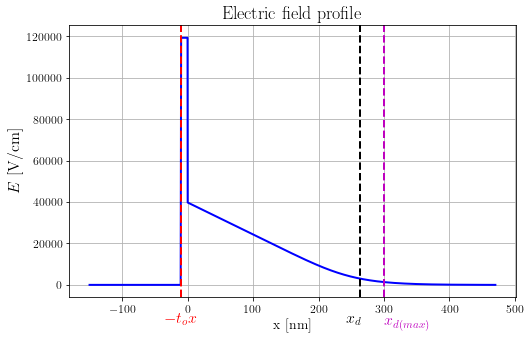

<Figure size 576x360 with 0 Axes>

In [6]:
if xd != 0:
    y_m    = np.linspace(-xlim/2*1e7,-tox*1e7,200)
else:
    y_m    = np.linspace(-11*tox*1e7,-tox*1e7,200)
y_ox   = np.linspace(-tox*1e7,0,50)
rho_ox = np.zeros_like(y_ox)

rho_m  = np.zeros_like(y_m)
y_si   = y
rho_si = rho


Elf_si = []

for i in range(y_si.size):
    Elf_si.append((1)/(es*e0)*simps(rho_si[0:i+1],y_si[0:i+1]*1e-7))

# set the zero of electric field at the bulk

Elf_si = Elf_si - Elf_si[-1]
Elf_ox = Elf_si[0]*np.ones_like(y_ox)*(es)/(eox)
Elf_m  = np.zeros_like(y_m)


y   = np.hstack((y_m[:-1],y_ox[:-1],y_si))
rho = np.hstack((rho_m[:-1],rho_ox[:-1],rho_si))

Elf = np.hstack((Elf_m[:-1],Elf_ox[:-1],Elf_si))

plt.figure(3)
plt.title("Electric field profile")
plt.xlabel('x [nm]', fontsize=14)
plt.ylabel('$E$ [V/cm]', fontsize=16)
plt.grid(True)
plt.plot(y, (Elf),'b', label='$\\rho/q$')

# plot relevant x poxitions
plt.axvline(x=-tox*1e7, color='r', linestyle='--')
if xd != 0:
    plt.axvline(x=xd*1e7, color='k', linestyle='--')
else:
    plt.axvline(x=LD*1e7, color='k', linestyle='--')
plt.axvline(x=xdM*1e7, color='m', linestyle='--')
ax = plt.gca()
plt.text(-tox*1e7, -.05, '$-t_ox$', color='r', transform=ax.get_xaxis_transform(), ha='center', va='top')
if xd != 0:
    plt.text(xd*1e7, -.05, '$x_d$', color='k', transform=ax.get_xaxis_transform(), ha='right', va='top')
else:
    plt.text(LD*1e7, -.05, '$L_D$', color='k', transform=ax.get_xaxis_transform(), ha='left', va='top')
plt.text(xdM*1e7, -.07, '$x_{d(max)}$', color='m', transform=ax.get_xaxis_transform(), ha='left', va='top')

plt.show()

plt.savefig("Images/Electric_field.pdf")

In [7]:
Elf_si[0]

39784.17843935505

# Potential

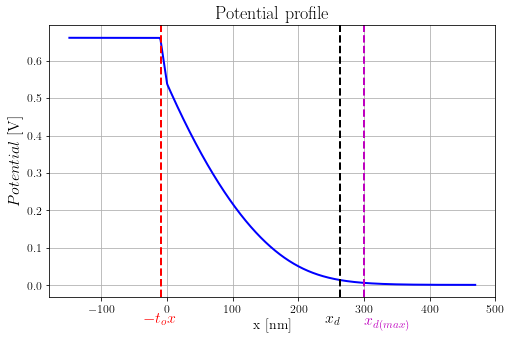

<Figure size 576x360 with 0 Axes>

In [8]:
def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

V_tot = []

for i in range(y.size):
    V_tot.append(-1*simps(Elf[0:i+1],y[0:i+1]*1e-7))

V_tot   = np.array(V_tot)
V_totma = moving_average(V_tot,4) - V_tot[-1]
y     = np.array(y)
yma   = moving_average(y,4)
    
# interpolate results
V_new = interp1d(yma, V_totma, kind='cubic')
y_new = np.linspace(yma[0],yma[-1],y.size*10)

plt.figure(3)
plt.title("Potential profile")
plt.xlabel('x [nm]', fontsize=14)
plt.ylabel('$Potential$ [V]', fontsize=16)
plt.grid(True)
tmp = plt.plot(y_new, (V_new(y_new)),'b')

# plot relevant x poxitions
plt.axvline(x=-tox*1e7, color='r', linestyle='--')
if xd != 0:
    plt.axvline(x=xd*1e7, color='k', linestyle='--')
else:
    plt.axvline(x=LD*1e7, color='k', linestyle='--')
plt.axvline(x=xdM*1e7, color='m', linestyle='--')
ax = plt.gca()
plt.text(-tox*1e7, -.05, '$-t_ox$', color='r', transform=ax.get_xaxis_transform(), ha='center', va='top')
if xd != 0:
    plt.text(xd*1e7, -.05, '$x_d$', color='k', transform=ax.get_xaxis_transform(), ha='right', va='top')
else:
    plt.text(LD*1e7, -.05, '$L_D$', color='k', transform=ax.get_xaxis_transform(), ha='left', va='top')
plt.text(xdM*1e7, -.07, '$x_{d(max)}$', color='m', transform=ax.get_xaxis_transform(), ha='left', va='top')

plt.show()

plt.savefig("Images/Potential.pdf")

In [9]:
DeltaV=V_tot[0]-V_tot[-1]
print ('Delta V = %0.4g V'  % (DeltaV))

Delta V = 0.6611 V


# Charge plots ("Approx")

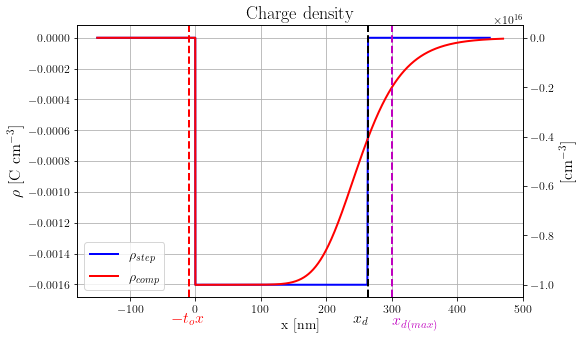

In [10]:
y_m_app     = y_m
y_ox_app    = y_ox
y_si_dr_app = np.linspace(0,xd*1e7,250)
y_si_b_app  = np.linspace(xd*1e7,1.5*xdM*1e7,250)

rho_m_app  = rho_m
rho_ox_app = rho_ox
rho_si_dr_app = q*(Nd-Na)*np.ones_like(y_si_dr_app)
rho_si_b_app  = np.zeros_like(y_si_b_app)

y_si_app   = np.hstack((y_si_dr_app[:-1],y_si_b_app))
y_app      = np.hstack((y_m_app[:-1],y_ox_app[:-1],y_si_dr_app[:-1],y_si_b_app))
rho_si_app = np.hstack((rho_si_dr_app[:-1], rho_si_b_app))
rho_app    = np.hstack((rho_m[:-1],rho_ox[:-1],rho_si_dr_app[:-1], rho_si_b_app))

y_comp     = y
rho_comp   = np.hstack((rho_m[:-1],rho_ox[:-1],rho))

plt.figure(3)
plt.title("Charge density")
plt.xlabel('x [nm]', fontsize=14)
plt.ylabel('$\\rho$ [C cm$^{-3}$]', fontsize=16)
plt.grid(True)

plt.plot(y_app, (rho_app),'b', label='$\\rho_{step}$')

plt.plot(y_comp, (rho),'r', label='$\\rho_{comp}$')

# plot relevant x poxitions
plt.axvline(x=-tox*1e7, color='r', linestyle='--')
if xd != 0:
    plt.axvline(x=xd*1e7, color='k', linestyle='--')
else:
    plt.axvline(x=LD*1e7, color='k', linestyle='--')
plt.axvline(x=xdM*1e7, color='m', linestyle='--')
ax = plt.gca()
plt.text(-tox*1e7, -.05, '$-t_ox$', color='r', transform=ax.get_xaxis_transform(), ha='center', va='top')
if xd != 0:
    plt.text(xd*1e7, -.05, '$x_d$', color='k', transform=ax.get_xaxis_transform(), ha='right', va='top')
else:
    plt.text(LD*1e7, -.05, '$L_D$', color='k', transform=ax.get_xaxis_transform(), ha='right', va='top')
plt.text(xdM*1e7, -.07, '$x_{d(max)}$', color='m', transform=ax.get_xaxis_transform(), ha='left', va='top')

plt.legend()

ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis

ax2.set_ylabel('[cm$^{-3}$]')  #
ax2.plot(y_app, rho_app/q, alpha=0.0)
ax2.tick_params(axis='y')

plt.savefig("Images/Charge_density_app.pdf")

# Electric field ("Approx")

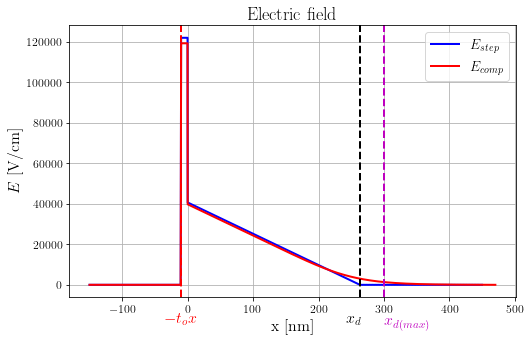

In [11]:
Elf_si_app = []

for i in range(y_si_app.size):
    Elf_si_app.append((1)/(es*e0)*simps(rho_si_app[0:i+1],y_si_app[0:i+1]*1e-7))

# set the zero of electric field at the bulk

Elf_si_app = Elf_si_app - Elf_si_app[-1]
Elf_ox_app = Elf_si_app[0]*np.ones_like(y_ox_app)*(es)/(eox)
Elf_m_app  = np.zeros_like(y_m_app)

Elf_app = np.hstack((Elf_m_app[:-1],Elf_ox_app[:-1],Elf_si_app))

plt.figure(1)
plt.title("Electric field")
plt.xlabel('x [nm]')
plt.ylabel('$E$ [V/cm]')
plt.grid(True)

plt.plot(y_app, (Elf_app),'b', label='$E_{step}$')

plt.plot(y, (Elf),'r', label='$E_{comp}$')


# plot relevant x poxitions
plt.axvline(x=-tox*1e7, color='r', linestyle='--')
if xd != 0:
    plt.axvline(x=xd*1e7, color='k', linestyle='--')
else:
    plt.axvline(x=LD*1e7, color='k', linestyle='--')
plt.axvline(x=xdM*1e7, color='m', linestyle='--')
ax = plt.gca()
plt.text(-tox*1e7, -.05, '$-t_ox$', color='r', transform=ax.get_xaxis_transform(), ha='center', va='top')
if xd != 0:
    plt.text(xd*1e7, -.05, '$x_d$', color='k', transform=ax.get_xaxis_transform(), ha='right', va='top')
else:
    plt.text(LD*1e7, -.05, '$L_D$', color='k', transform=ax.get_xaxis_transform(), ha='right', va='top')
plt.text(xdM*1e7, -.07, '$x_{d(max)}$', color='m', transform=ax.get_xaxis_transform(), ha='left', va='top')

plt.legend()

plt.savefig("Images/Electric_field_app.pdf")

In [12]:
Elf_ox_app[0]

122085.57998561837

# Potential ("Approx")

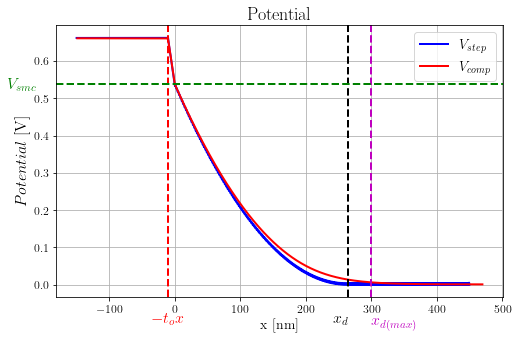

In [13]:
V_app_tot = []

for i in range(y_app.size):
    V_app_tot.append(-1*simps(Elf_app[0:i+1],y_app[0:i+1]*1e-7))

V_app_tot = V_app_tot -V_app_tot[-1]
    
# interpolate results
V_app_new = interp1d(y_app, V_app_tot, kind='cubic')
y_app_new = np.linspace(y_app[0],y_app[-1],y_app.size*10)

plt.figure(3)
plt.title("Potential")
plt.xlabel('x [nm]', fontsize=14)
plt.ylabel('$Potential$ [V]', fontsize=16)
plt.grid(True)

plt.plot(y_app_new, (V_app_new(y_app_new)),'b', label='$V_{step}$')

plt.plot(y_new, (V_new(y_new)),'r', label='$V_{comp}$')

# plot relevant x poxitions
plt.axvline(x=-tox*1e7, color='r', linestyle='--')
plt.axvline(x=xd*1e7, color='k', linestyle='--')
plt.axvline(x=xdM*1e7, color='m', linestyle='--')
ax = plt.gca()
plt.text(-tox*1e7, -.05, '$-t_ox$', color='r', transform=ax.get_xaxis_transform(), ha='center', va='top')
plt.text(xd*1e7, -.05, '$x_d$', color='k', transform=ax.get_xaxis_transform(), ha='right', va='top')
plt.text(xdM*1e7, -.07, '$x_{d(max)}$', color='m', transform=ax.get_xaxis_transform(), ha='left', va='top')

plt.axhline(y=psis, color='g', linestyle='--')
ax.text(-0.11, psis, '$V_{smc}$', color='g', transform=ax.get_yaxis_transform(), ha='left', va='center')
         
plt.legend()


plt.savefig("Images/Potential_app.pdf")

In [14]:
DeltaV_app=V_app_tot[0]-V_app_tot[-1]
print ('Delta V = %0.4g V'  % (DeltaV_app))

Delta V = 0.6621 V
